# Brain Tumor Classification (CMPS 261 - Spring 2025)

This notebook trains a deep learning model to classify brain MRI scans as either containing a tumor or not. 
The dataset contains `.jpg` images and `.txt` labels. This project focuses on the classification aspect.

## Workflow:
1. Load and clean dataset
2. Build TensorFlow data pipeline
3. Build and train CNN model
4. Evaluate and save model


## 1. Dataset Preparation

We load and organize the dataset, which consists of brain MRI images and associated label files.
Each label indicates the presence of a tumor (1) or not (0), along with bounding box data — which we ignore for negative samples, per instructor instructions.

### Loading & Understanding our Data:

In [24]:
import os

# Defining paths to image and label folders respectively:
image_dir = './data/images/'
label_dir = './data/labels/'

# Count # of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
num_images = len(image_files)

print(f"Total number of images: {num_images}")

# Count # of text files
image_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
num_labels = len(image_files)

print(f"Total number of labels: {num_labels}")

# Check how many images are missing labels
print(f'There are {num_images - num_labels} images missing a label!')

Total number of images: 893
Total number of labels: 878
There are 15 images missing a label!


### Before proceeding this is a basic example of how we can use the label + BBOX info to display the tumor:

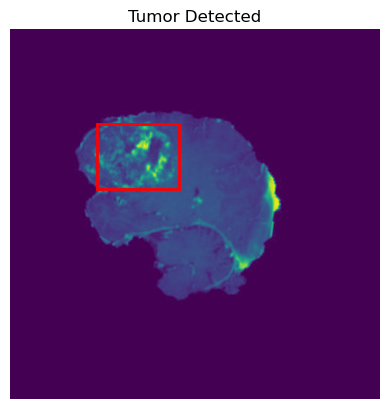

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# === Step 1: Load the image ===
image_path = image_dir + '00054_145.jpg'
label_path = label_dir + '00054_145.txt'

image = Image.open(image_path)
img_width, img_height = image.size

# === Step 2: Read the label ===
with open(label_path, 'r') as f:
    line = f.readline().strip()
    parts = line.split()
    label = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

# === Step 3: Convert normalized values to pixels ===
x_center_pixel = x_center * img_width
y_center_pixel = y_center * img_height
box_width_pixel = width * img_width
box_height_pixel = height * img_height

# Convert from center to top-left corner
x_min = x_center_pixel - (box_width_pixel / 2)
y_min = y_center_pixel - (box_height_pixel / 2)

# === Step 4: Plot image and box ===
fig, ax = plt.subplots(1)
ax.imshow(image)

# Only draw the box if there's a tumor
if label == 1:
    rect = patches.Rectangle(
        (x_min, y_min),
        box_width_pixel,
        box_height_pixel,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    plt.title("Tumor Detected")
else:
    plt.title("No Tumor")

plt.axis('off')
plt.show()

### Okay, now that we understand how the data can be used let's find how many usable pairs we have:

In [26]:
# Helper: get filenames without extension
image_files = set(f[:-4] for f in os.listdir(image_dir) if f.endswith('.jpg'))
label_files = set(f[:-4] for f in os.listdir(label_dir) if f.endswith('.txt'))

# Intersection → only matched pairs
valid_ids = sorted(image_files & label_files)
print(f"Total valid image-label pairs: {len(valid_ids)}")

# Final dataset list
dataset = []

for img_id in valid_ids:
    label_path = os.path.join(label_dir, img_id + '.txt')
    image_path = os.path.join(image_dir, img_id + '.jpg')
    
    with open(label_path, 'r') as f:
        parts = f.readline().strip().split()
        label = int(parts[0])

        if label == 0:
            # No tumor: ignore bbox
            dataset.append((image_path, label, None))
        else:
            # Tumor: include bbox
            bbox = list(map(float, parts[1:]))
            dataset.append((image_path, label, bbox))

print(f"Prepared dataset with {len(dataset)} usable samples")

Total valid image-label pairs: 878
Prepared dataset with 878 usable samples


## 2. Data Pipeline with `tf.data`

Now that we've bundled our pairs we can create a TensorFlow data pipeline to efficiently load, process, and batch images for training.
This includes:
- Reading image files
- Resizing and normalizing
- Batching and prefetching for performance

In [27]:
import tensorflow as tf

# === Settings ===
IMG_SIZE = (224, 224)       # Target image dimensions (height, width)
BATCH_SIZE = 32             # Number of samples per training batch

# === Step 1: Creating TensorFlow Dataset Pipeline ===
def data_generator():
    """Generator that yields (image_path, label, bbox) tuples from the dataset."""
    for image_path, label, bbox in dataset:
        # For negative samples (label == 0), supply a dummy bbox
        if bbox is None:
            bbox = [0.0, 0.0, 0.0, 0.0]
        yield image_path.encode(), label, bbox  # Encode path as bytes for TensorFlow

# Define the output signature for the base dataset
output_signature = (
    tf.TensorSpec(shape=(), dtype=tf.string),   # image_path (scalar string)
    tf.TensorSpec(shape=(), dtype=tf.int32),    # label (scalar integer)
    tf.TensorSpec(shape=(4,), dtype=tf.float32) # bbox (4 float values: x_center, y_center, width, height)
)

# Create the base dataset from the generator
base_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=output_signature
)

# === Step 2: Image Preprocessing Function ===
# Now we define a helper method for image preprocessing.
def load_and_preprocess(image_path, label, bbox):
    """Load, decode, and preprocess an image and its label.
    Args:
        image_path: Path to the image file (tf.string).
        label: Class label (0 = no tumor, 1 = tumor).
        bbox: Bounding box coordinates (ignored in this function).
    Returns:
        Tuple of (normalized image tensor, label).
    """
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure RGB format
    image = tf.image.resize(image, IMG_SIZE)         # Resize to target dimensions
    image = tf.cast(image, tf.float32) / 255.0       # Normalize pixel values to [0, 1]
    return image, label # I'm igoring bbox for now!

# === Step 3: Optimize the Dataset Pipeline ===
final_dataset = (
    base_dataset
    .map(load_and_preprocess)    # Apply preprocessing to each element
    .shuffle(1000)               # Shuffle with a buffer of 1000 samples
    .batch(BATCH_SIZE)           # Group samples into batches
    .prefetch(tf.data.AUTOTUNE)  # Overlap data preprocessing and model execution
    .repeat()
)

print("✅ Dataset pipeline created.")

✅ Dataset pipeline created.


### Quick pipeline test:

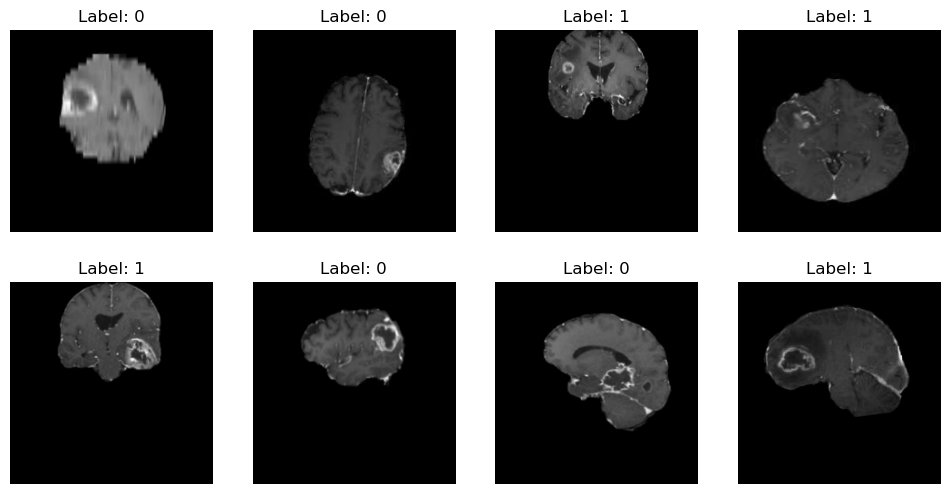

In [28]:
for images, labels in final_dataset.take(1):
    plt.figure(figsize=(12, 6))
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

## 3. Model Architecture (Transfer Learning)

We use MobileNetV2 as a pretrained CNN backbone, removing its top classification layers.
A custom head is added for binary classification (tumor vs. no tumor), using:
- Global average pooling
- Dense layers
- Dropout for regularization

### Load pretrained model:

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# === Load Pretrained MobileNetV2 (without top classifier) ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,       # Exclude the original classification head
    weights='imagenet'       # Load pretrained weights from ImageNet
)
base_model.trainable = False  # Freeze the base

# === Add Custom Classification Head ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),           # Reduce feature maps to a vector
    layers.Dense(128, activation='relu'),      # Optional fully connected layer
    layers.Dropout(0.3),                       # Regularization
    layers.Dense(1, activation='sigmoid')      # Output layer for binary classification
])

### Compile Model:

In [30]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Model:

We train the model on the preprocessed dataset using 10 epochs.
The dataset is repeated to support multiple epochs, and steps per epoch are calculated based on batch size.

In [32]:
EPOCHS = 10
steps_per_epoch = len(dataset) // BATCH_SIZE

history = model.fit(
    final_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.5210 - loss: 0.8551
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.6391 - loss: 0.6225
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.6428 - loss: 0.6196
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.7032 - loss: 0.5662
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.7555 - loss: 0.5156
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7248 - loss: 0.5327
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 243ms/step - accuracy: 0.7681 - loss: 0.4810
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.7775 - loss: 0.4572
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 244ms/step - accuracy: 0.7788 - loss: 0.4535
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.8064 - loss: 0.4107


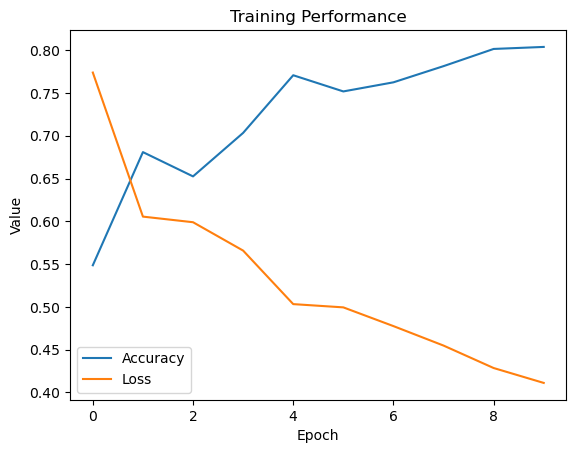

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Training Performance')
plt.show()

## 4. Model Evaluation & Saving

We evaluate model performance on a held-out 20% validation set using accuracy and loss metrics.
This helps confirm generalization and detect overfitting.


In [34]:
from sklearn.model_selection import train_test_split

# Split the original list of tuples (image_path, label, bbox)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=1)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")

Train size: 702
Validation size: 176


In [35]:
def val_generator():
    for image_path, label, bbox in val_data:
        if bbox is None:
            bbox = [0.0, 0.0, 0.0, 0.0]
        yield image_path.encode(), label, bbox

val_output_signature = (
    tf.TensorSpec(shape=(), dtype=tf.string),
    tf.TensorSpec(shape=(), dtype=tf.int32),
    tf.TensorSpec(shape=(4,), dtype=tf.float32)
)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=val_output_signature
)

val_dataset = (
    val_dataset
    .map(load_and_preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [36]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.9063 - loss: 0.3513
Validation Accuracy: 0.9091
Validation Loss: 0.3423


### Save the Trained Model

The model is saved as a `.h5` file, preserving both the architecture and weights.
This allows future reuse for inference or deployment.

In [37]:
model.save("brain_tumor_model.h5")